In [3]:
from google.colab import files
import os

if not os.path.exists("quantum_dataset_long.csv"):
    uploaded = files.upload()
else:
    print("Dataset already exists, skipping upload")

Saving quantum_dataset_long.csv to quantum_dataset_long (1).csv


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

try:
    df = pd.read_csv("quantum_dataset_long.csv")
    print(f"Dataset Loaded Successfully: {len(df)} samples")
except FileNotFoundError:
    raise FileNotFoundError("file not found")

In [ ]:
input_cols = ["n_qubits", "n_gates", "depth", "noise_level"]
for i in range(16):
    input_cols.append(f"noisy_{i}")

target_cols = [f"ideal_{i}" for i in range(16)]

X_numpy = df[input_cols].values.astype(np.float32)
Y_numpy = df[target_cols].values.astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y_numpy, test_size=0.2, random_state=42)

X_train_gpu = torch.tensor(X_train).to(device)
Y_train_gpu = torch.tensor(Y_train).to(device)
X_test_gpu = torch.tensor(X_test).to(device)
Y_test_gpu = torch.tensor(Y_test).to(device)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data:  {X_test.shape}")

In [ ]:
class QuantumErrorMitigator(nn.Module):
    def __init__(self):
        super(QuantumErrorMitigator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(20, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 16),
            # LogSoftmax since ill be using KLDivergence loss
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = QuantumErrorMitigator().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.KLDivLoss(reduction='batchmean')

EPOCHS = 500
train_losses = []
test_losses = []

best_test_loss = float('inf')
best_model_weights = None

pbar = tqdm(range(EPOCHS))

for epoch in pbar:
    model.train()
    optimizer.zero_grad()

    log_preds = model(X_train_gpu)
    loss = criterion(log_preds, Y_train_gpu)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_log_preds = model(X_test_gpu)
        test_loss = criterion(test_log_preds, Y_test_gpu)
        test_losses.append(test_loss.item())

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model_weights.pth")

    if epoch % 50 == 0:
        pbar.set_description(f"Epoch {epoch} | Val Loss: {test_loss.item():.6f}")

print(f"\nTraining Complete. Best Validation Loss: {best_test_loss:.6f}")

model.load_state_dict(best_model_weights)
print("Best model weights reloaded for evaluation.")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss (KL)")
plt.plot(test_losses, label="Validation Loss (KL)", linestyle="--")
min_idx = np.argmin(test_losses)
plt.scatter(min_idx, test_losses[min_idx], c='red', marker='*', s=150, zorder=5, label=f"Best Model (Epoch {min_idx})")

plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Loss (KL Divergence)")
plt.title("Training Trajectory")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    log_output = model(X_test_gpu)
    # 2. Convert Log-Probs -> Actual Probs for Metric Calculation
    Y_pred_ai = torch.exp(log_output).cpu().numpy()

# Get Ground Truth & Noisy Input
Y_truth = Y_test_gpu.cpu().numpy()
X_noisy_input = X_test_gpu[:, 4:].cpu().numpy()

# using MSE here for the report because it's easier to interpret physically than KL
mse_unmitigated = ((Y_truth - X_noisy_input) ** 2).mean(axis=1)
mse_ai = ((Y_truth - Y_pred_ai) ** 2).mean(axis=1)

r2_baseline = r2_score(Y_truth, X_noisy_input)
r2_ai = r2_score(Y_truth, Y_pred_ai)

avg_noise_error = mse_unmitigated.mean()
avg_ai_error = mse_ai.mean()
improvement_factor = avg_noise_error / avg_ai_error
win_rate = np.sum(mse_ai < mse_unmitigated) / len(mse_ai) * 100

print(f"\nFINAL PERFORMANCE REPORT (Evaluated on {len(mse_ai)} Test Samples)")
print("=" * 60)
print(f"MSE Error (Unmitigated):   {avg_noise_error:.6f}")
print(f"MSE Error (AI Model):      {avg_ai_error:.6f}")
print("-" * 60)
print(f"R2 Score (Unmitigated):    {r2_baseline:.4f} (Baseline Fit)")
print(f"R2 Score (AI Model):       {r2_ai:.4f} (AI Fit)")
print("-" * 60)
print(f"Improvement Factor:        {improvement_factor:.2f}x")
print(f"Win Rate:                  {win_rate:.2f}%")
print("=" * 60)


FINAL PERFORMANCE REPORT (Evaluated on 6000 Test Samples)
MSE Error (Unmitigated):   0.018641
MSE Error (AI Model):      0.010565
------------------------------------------------------------
R2 Score (Unmitigated):    0.1811 (Baseline Fit)
R2 Score (AI Model):       0.3832 (AI Fit)
------------------------------------------------------------
Improvement Factor:        1.76x
Win Rate:                  74.35%


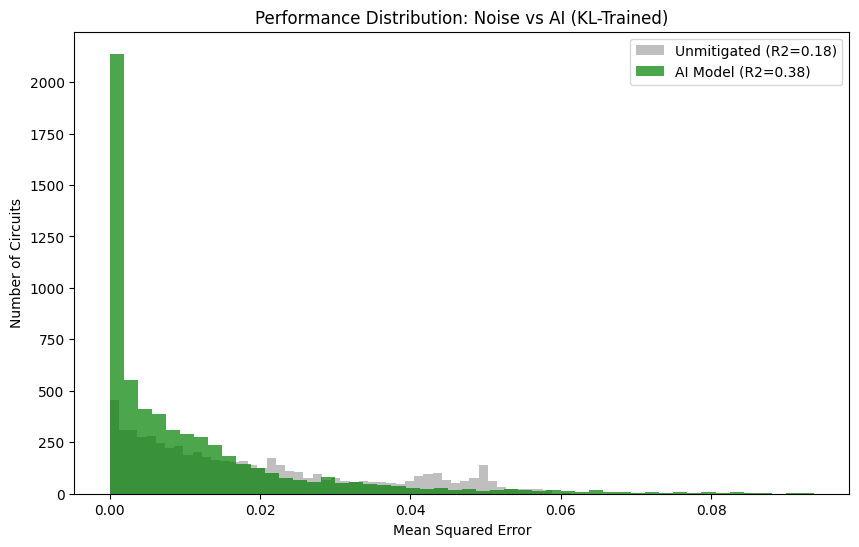

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(mse_unmitigated, bins=50, alpha=0.5, label=f'Unmitigated (R2={r2_baseline:.2f})', color='gray')
plt.hist(mse_ai, bins=50, alpha=0.7, label=f'AI Model (R2={r2_ai:.2f})', color='green')
plt.xlabel('Mean Squared Error')
plt.ylabel('Number of Circuits')
plt.title('Performance Distribution: Noise vs AI (KL-Trained)')
plt.legend()
plt.show()

In [19]:
print("\nDetailed Check (First 5 Samples)")
print(f"{'Metric':<20} | {'Unmitigated':<20} | {'AI Model':<20}")
print("-" * 65)
for i in range(10):
    status = "better" if mse_ai[i] < mse_unmitigated[i] else "not"
    print(f"Sample {i+1} {status}      | {mse_unmitigated[i]:.6f}             | {mse_ai[i]:.6f}")


Detailed Check (First 5 Samples)
Metric               | Unmitigated          | AI Model            
-----------------------------------------------------------------
Sample 1 better      | 0.019328             | 0.011667
Sample 2 not      | 0.002215             | 0.004267
Sample 3 not      | 0.012755             | 0.013399
Sample 4 better      | 0.002243             | 0.000260
Sample 5 better      | 0.014946             | 0.014004
Sample 6 not      | 0.004577             | 0.011582
Sample 7 better      | 0.038150             | 0.000001
Sample 8 better      | 0.020751             | 0.018917
Sample 9 better      | 0.014594             | 0.003167
Sample 10 better      | 0.000626             | 0.000047


In [ ]:
try:
    from google.colab import files
    files.download('best_model_weights.pth')
    print("Download started...")
except ImportError:
    print("Saved locally as 'best_model_weights.pth'")